In [1]:
!pip -q install imbalanced-learn wordcloud

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Tweets.csv to Tweets.csv


In [3]:
import pandas as pd

df = pd.read_csv("Tweets.csv")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (14640, 15)
Columns: ['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone']


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# Keep only text and sentiment columns
df = df[['text', 'airline_sentiment']]

# Drop any rows with missing text or sentiment
df = df.dropna(subset=['text', 'airline_sentiment'])

# Quick check of sentiment distribution
print(df['airline_sentiment'].value_counts())

# Preview cleaned data
df.head()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Separate features (X) and labels (y)
X = df['text']
y = df['airline_sentiment']

# Split dataset into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert text into TF-IDF features
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF shape (train):", X_train_tfidf.shape)
print("TF-IDF shape (test):", X_test_tfidf.shape)

TF-IDF shape (train): (11712, 5000)
TF-IDF shape (test): (2928, 5000)


SVM Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.90      0.86      1835
     neutral       0.59      0.54      0.56       620
    positive       0.75      0.62      0.68       473

    accuracy                           0.77      2928
   macro avg       0.73      0.68      0.70      2928
weighted avg       0.77      0.77      0.77      2928



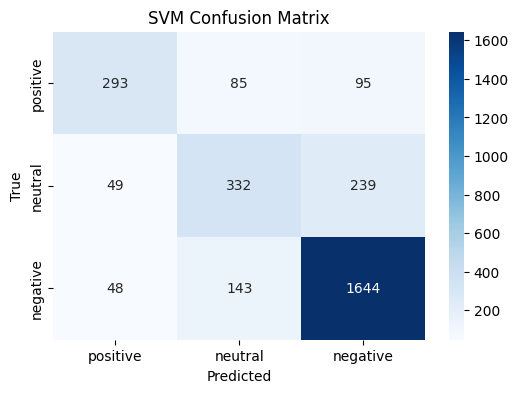

In [6]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train the model
svm_clf = LinearSVC()
svm_clf.fit(X_train_tfidf, y_train)

# Predictions
y_pred_svm = svm_clf.predict(X_test_tfidf)

# Evaluation
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_svm, labels=['positive', 'neutral', 'negative'])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'neutral', 'negative'],
            yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM Confusion Matrix")
plt.show()

Weighted SVM Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.85      0.86      1835
     neutral       0.56      0.60      0.58       620
    positive       0.71      0.67      0.69       473

    accuracy                           0.77      2928
   macro avg       0.71      0.71      0.71      2928
weighted avg       0.77      0.77      0.77      2928



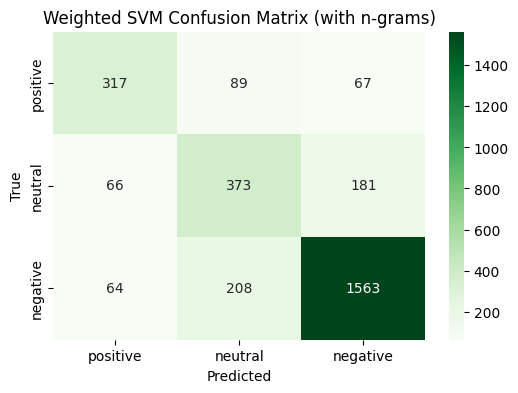

In [7]:
# Rebuild TF-IDF with n-grams (1 word or 2-word combinations)
tfidf_ngram = TfidfVectorizer(stop_words='english', max_features=8000, ngram_range=(1,2))
X_train_tfidf_ngram = tfidf_ngram.fit_transform(X_train)
X_test_tfidf_ngram = tfidf_ngram.transform(X_test)

# Train SVM with class weights to handle imbalance
svm_weighted = LinearSVC(class_weight='balanced', max_iter=5000)
svm_weighted.fit(X_train_tfidf_ngram, y_train)

# Predictions
y_pred_weighted = svm_weighted.predict(X_test_tfidf_ngram)

# Evaluation
print("Weighted SVM Classification Report:")
print(classification_report(y_test, y_pred_weighted))

# Confusion matrix
cm_w = confusion_matrix(y_test, y_pred_weighted, labels=['positive', 'neutral', 'negative'])

plt.figure(figsize=(6,4))
sns.heatmap(cm_w, annot=True, fmt='d', cmap='Greens',
            xticklabels=['positive', 'neutral', 'negative'],
            yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Weighted SVM Confusion Matrix (with n-grams)")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network (MLP) Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.88      0.86      1835
     neutral       0.56      0.55      0.55       620
    positive       0.72      0.61      0.66       473

    accuracy                           0.76      2928
   macro avg       0.70      0.68      0.69      2928
weighted avg       0.76      0.76      0.76      2928



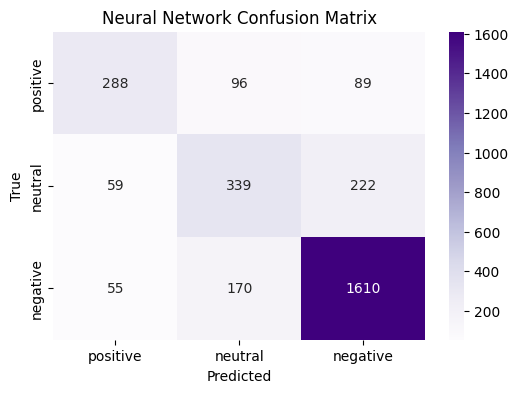

In [10]:
from sklearn.neural_network import MLPClassifier

# Train neural network
mlp = MLPClassifier(hidden_layer_sizes=(100,),
                    activation='relu',
                    solver='adam',
                    max_iter=10,
                    random_state=42)
mlp.fit(X_train_tfidf_ngram, y_train)

# Predictions
y_pred_mlp = mlp.predict(X_test_tfidf_ngram)

# Evaluation
print("Neural Network (MLP) Classification Report:")
print(classification_report(y_test, y_pred_mlp))

# Confusion matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp, labels=['positive', 'neutral', 'negative'])

plt.figure(figsize=(6,4))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Purples',
            xticklabels=['positive', 'neutral', 'negative'],
            yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Neural Network Confusion Matrix")
plt.show()